# Library install

In [ ]:
pip install nibabel pandas numpy scipy openpyxl imageio

# Preprocessing_241008수정본

In [5]:
import os
import imageio
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

####################################
## 0. 데이터 로드
####################################
# 경로 설정
excel_file_path = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx"
data_dir = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset"

# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

####################################
## 1. 결측값 제거
####################################

# (1) 첫 번째 결측값 제거 전 데이터 개수 및 결측값 개수 확인
print(f"RAW 데이터 개수: {len(df)}")
missing_initial = df[df.isna().any(axis=1)]
print(f"RAW ID 목록: {missing_initial['ID'].tolist()}")

# CDR 값이 없는 경우, 결측값으로 간주하고 제거
removed_ids = df[df['CDR'].isna()]['ID'].tolist()  # 제거될 ID 목록 저장
df_before = len(df)  # 제거 전 개수 기록
df = df.dropna(subset=['CDR'])
df_after = len(df)

print(f"CDR 기준 제거된 개수: {df_before - df_after}")
print(f"CDR 기준 제거된 ID 목록: {removed_ids}")


# MRI, label, 인구통계 정보를 위한 리스트와 딕셔너리 생성
coronal_images = {}
sagittal_images = {}
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []
demographics = {}

# 이미지 크기 조정 함수 정의 (이미지를 224x224로 변환)
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]  # 2D 이미지이므로 앞의 두 차원만 사용 (높이, 너비)
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)] # 비율 차이 계산
    return zoom(image, zoom_factors) # 이미지 확대/축소 함수

# 피험자 데이터 로드 및 저장
# 먼저 12개의 디스크를 병합하여 처리
for disc_num in range(1, 13):  # 1~12 디스크 (OASIS 디스크 12개)
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")
    
    # [디버깅] 디스크 경로가 존재하는지 확인
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue
    
    for sub_folder in os.listdir(disc_path):  # disc 안의 폴더 탐색
        sub_folder_path = os.path.join(disc_path, sub_folder)
        
        if not os.path.isdir(sub_folder_path):  # [디버깅] 폴더가 아닌 경우 무시
            print(f"Skipping non-directory: {sub_folder_path}")
            continue
        
        for subject_dir in os.listdir(sub_folder_path):  # 피험자 폴더 탐색
            subject_path = os.path.join(sub_folder_path, subject_dir)
            
            if not os.path.isdir(subject_path): # [디버깅] 폴더가 아닌 경우 무시
                print(f"Skipping non-directory: {subject_path}")
                continue

            # MRI 경로 설정
            session_path = subject_path
            print(f"Processing session: {session_path}")

            if not os.path.exists(session_path): # [디버깅]
                print(f"Session path does not exist: {session_path}")
                continue

            # preprocessed 데이터 경로 (T88_111 폴더)
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            print(f"Checking T88_111 path: {t88_111_path}")

            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # coronal 이미지 처리
                    if file.endswith("_cor_110.gif"):
                        print(f"Loading coronal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            coronal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading coronal image: {e}")

                    # sagittal 이미지 처리
                    elif file.endswith("_sag_95.gif"):
                        print(f"Loading sagittal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            sagittal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading sagittal image: {e}")

                    # transverse 이미지 처리
                    elif file.endswith("_tra_90.gif"):
                        if "masked_gfc" in file:
                            print(f"Loading masked transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_masked[subject_dir] = img_resized
                            except Exception as e: # [디버깅]
                                print(f"Error loading masked transverse image: {e}")
                        else:
                            print(f"Loading regular transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_gfc[subject_dir] = img_resized
                            except Exception as e: #[디버깅]
                                print(f"Error loading regular transverse image: {e}")

                    # 피험자 ID 그대로 추출
                    subject_id = subject_dir

                    # 엑셀에서 해당 ID를 매칭하고 정보를 찾기
                    subject_info = df[df['ID'] == subject_id]

                    if not subject_info.empty:
                        # CDR 값을 label로 사용
                        cdr_value = subject_info['CDR'].values[0]
                        labels.append(cdr_value)

                        # 인구통계학적 정보 딕셔너리에 저장
                        demographics[subject_id] = {
                            'M/F': subject_info['M/F'].values[0],
                            'Hand': subject_info['Hand'].values[0],
                            'Age': subject_info['Age'].values[0],
                            'Educ': subject_info['Educ'].values[0],
                            'SES': subject_info['SES'].values[0],
                            'MMSE': subject_info['MMSE'].values[0],
                            'eTIV': subject_info['eTIV'].values[0],
                            'nWBV': subject_info['nWBV'].values[0],
                            'ASF': subject_info['ASF'].values[0],
                            'Delay': subject_info['Delay'].values[0]
                        }
                    else:
                        print(f"Label not found for subject: {subject_id}")  # label이 없는 피험자 출력
            else:
                print(f"T88_111 path does not exist: {t88_111_path}")

# (2) label과 MRI가 동시에 존재하지 않는 피실험자의 결측값 개수 및 ID 출력
missing_subjects = []
for subject in df['ID']:
    missing_images = []
    if subject not in coronal_images:
        missing_images.append("coronal")
    if subject not in sagittal_images:
        missing_images.append("sagittal")
    if subject not in transverse_images_gfc and subject not in transverse_images_masked:
        missing_images.append("transverse")
    
    if missing_images:
        missing_subjects.append((subject, missing_images))

print(f"총 결측 피실험자 수: {len(missing_subjects)}")
for subject, missing_types in missing_subjects:
    print(f"ID: {subject}, 결측 이미지 타입: {', '.join(missing_types)}")


# 결측값 처리: label와 mri가 동시에 존재하는 피실험자만 데이터셋으로 사용하기
valid_subjects = [subject for subject in demographics if subject in df['ID'].values]
coronal_images = {subject: coronal_images[subject] for subject in valid_subjects if subject in coronal_images}
sagittal_images = {subject: sagittal_images[subject] for subject in valid_subjects if subject in sagittal_images}
transverse_images_gfc = {subject: transverse_images_gfc[subject] for subject in valid_subjects if subject in transverse_images_gfc}
transverse_images_masked = {subject: transverse_images_masked[subject] for subject in valid_subjects if subject in transverse_images_masked}
labels = [df[df['ID'] == subject]['CDR'].values[0] for subject in valid_subjects]

# 1차 최종 정보 출력
print(f"Coronal images: {len(coronal_images)}")
print(f"Sagittal images: {len(sagittal_images)}")
print(f"Regular transverse images: {len(transverse_images_gfc)}")
print(f"Masked transverse images: {len(transverse_images_masked)}")
print(f"총 label: {len(labels)}")
print(f"저장된 피험자 수: {len(demographics)}")

####################################
## 2. Label 인코딩
####################################
def convert_images_to_array(image_dict):
    image_array = []
    for img in image_dict.values():
        # if 이미지가 흑백인 경우 : 채널을 추가하는 코드 - 모델에 입력 가능한 형태인 (height, width, 1)로 맞춤
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        image_array.append(img)
    return np.array(image_array)

# 전체 치매군과 비치매군 인원수 출력
dementia_count = sum([1 if cdr >= 0.5 else 0 for cdr in labels])
non_dementia_count = len(labels) - dementia_count
print(f"Total Dementia: {dementia_count}, Total Non-dementia: {non_dementia_count}")

# 비치매군을 치매군의 개수에 맞게 랜덤 추출 (과적합 방지를 위해)
non_dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr == 0]
np.random.seed(42)
non_dementia_subjects_balanced = np.random.choice(non_dementia_subjects, size=dementia_count, replace=False).tolist()

# 치매군과 밸런스맞춘 비치매군의 데이터셋을 합침
dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr >= 0.5]
balanced_subjects = dementia_subjects + non_dementia_subjects_balanced

# label 1은 치매, label 0은 비치매로 설정
balanced_labels = [1] * len(dementia_subjects) + [0] * len(non_dementia_subjects_balanced)
# 3. 정규화(Normalization) -> 정규화를 데이터셋 분리 전에 먼저 수행
####################################
## 3. 정규화(Normalization)
####################################
# 정규화 함수 정의 (이미지의 픽셀 값을 0에서 1 사이로 정규화)
def normalize_image(image):
    # 이미지의 최대값이 0이 아니어야 정규화를 진행
    if image.max() > 0:
        return image / 255.0
    else:
        return image

# 정규화 적용 및 정규화 전후 값 출력 [디버깅]
def normalize_and_compare(image_array, image_type):
    # print(f"Before Normalization: {image_type} Min={image_array.min()}, Max={image_array.max()}")  # 필요에 따라 디버깅
    normalized_images = normalize_image(image_array)
    # print(f"After Normalization: {image_type} Min={normalized_images.min()}, Max={normalized_images.max()}")  # 필요에 따라 디버깅
    return normalized_images

# 이미지 배열에 정규화 적용
coronal_images_normalized = {subject: normalize_and_compare(img, 'Coronal') for subject, img in coronal_images.items()}
sagittal_images_normalized = {subject: normalize_and_compare(img, 'Sagittal') for subject, img in sagittal_images.items()}
transverse_images_gfc_normalized = {subject: normalize_and_compare(img, 'Transverse GFC') for subject, img in transverse_images_gfc.items()}
transverse_images_masked_normalized = {subject: normalize_and_compare(img, 'Transverse Masked') for subject, img in transverse_images_masked.items()}

# 데이터셋을 분리하기 전에 정규화하기 // 데이터별로 달라질까봐

####################################
## 4. 데이터셋 분리
####################################
# 데이터셋을 train/validation/test로 분할
train_subjects, temp_subjects, train_labels, temp_labels = train_test_split(
    balanced_subjects, balanced_labels, test_size=0.3, stratify=balanced_labels, random_state=42
)

val_subjects, test_subjects, val_labels, test_labels = train_test_split(
    temp_subjects, temp_labels, test_size=2/3, stratify=temp_labels, random_state=42
)

# 각 세트에 맞는 이미지들 준비 (coronal, sagittal, transverse, transverse_masked)
train_coronal = convert_images_to_array({subject: coronal_images_normalized[subject] for subject in train_subjects if subject in coronal_images_normalized})
val_coronal = convert_images_to_array({subject: coronal_images_normalized[subject] for subject in val_subjects if subject in coronal_images_normalized})
test_coronal = convert_images_to_array({subject: coronal_images_normalized[subject] for subject in test_subjects if subject in coronal_images_normalized})

train_sagittal = convert_images_to_array({subject: sagittal_images_normalized[subject] for subject in train_subjects if subject in sagittal_images_normalized})
val_sagittal = convert_images_to_array({subject: sagittal_images_normalized[subject] for subject in val_subjects if subject in sagittal_images_normalized})
test_sagittal = convert_images_to_array({subject: sagittal_images_normalized[subject] for subject in test_subjects if subject in sagittal_images_normalized})

train_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc_normalized[subject] for subject in train_subjects if subject in transverse_images_gfc_normalized})
val_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc_normalized[subject] for subject in val_subjects if subject in transverse_images_gfc_normalized})
test_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc_normalized[subject] for subject in test_subjects if subject in transverse_images_gfc_normalized})

train_transverse_masked = convert_images_to_array({subject: transverse_images_masked_normalized[subject] for subject in train_subjects if subject in transverse_images_masked_normalized})
val_transverse_masked = convert_images_to_array({subject: transverse_images_masked_normalized[subject] for subject in val_subjects if subject in transverse_images_masked_normalized})
test_transverse_masked = convert_images_to_array({subject: transverse_images_masked_normalized[subject] for subject in test_subjects if subject in transverse_images_masked_normalized})

# 최종 데이터셋 출력
print(f"Train set: {len(train_subjects)} subjects (Dementia: {sum(train_labels)}, Non-dementia: {len(train_labels) - sum(train_labels)})")
print(f"Validation set: {len(val_subjects)} subjects (Dementia: {sum(val_labels)}, Non-dementia: {len(val_labels) - sum(val_labels)})")
print(f"Test set: {len(test_subjects)} subjects (Dementia: {sum(test_labels)}, Non-dementia: {len(test_labels) - sum(test_labels)})")


RAW 데이터 개수: 436
RAW ID 목록: ['OAS1_0001_MR1', 'OAS1_0002_MR1', 'OAS1_0003_MR1', 'OAS1_0004_MR1', 'OAS1_0005_MR1', 'OAS1_0006_MR1', 'OAS1_0007_MR1', 'OAS1_0009_MR1', 'OAS1_0010_MR1', 'OAS1_0011_MR1', 'OAS1_0012_MR1', 'OAS1_0013_MR1', 'OAS1_0014_MR1', 'OAS1_0015_MR1', 'OAS1_0016_MR1', 'OAS1_0017_MR1', 'OAS1_0018_MR1', 'OAS1_0019_MR1', 'OAS1_0020_MR1', 'OAS1_0021_MR1', 'OAS1_0022_MR1', 'OAS1_0023_MR1', 'OAS1_0025_MR1', 'OAS1_0026_MR1', 'OAS1_0027_MR1', 'OAS1_0028_MR1', 'OAS1_0029_MR1', 'OAS1_0030_MR1', 'OAS1_0031_MR1', 'OAS1_0032_MR1', 'OAS1_0033_MR1', 'OAS1_0034_MR1', 'OAS1_0035_MR1', 'OAS1_0037_MR1', 'OAS1_0038_MR1', 'OAS1_0039_MR1', 'OAS1_0040_MR1', 'OAS1_0041_MR1', 'OAS1_0042_MR1', 'OAS1_0043_MR1', 'OAS1_0044_MR1', 'OAS1_0045_MR1', 'OAS1_0046_MR1', 'OAS1_0047_MR1', 'OAS1_0049_MR1', 'OAS1_0050_MR1', 'OAS1_0051_MR1', 'OAS1_0052_MR1', 'OAS1_0053_MR1', 'OAS1_0054_MR1', 'OAS1_0055_MR1', 'OAS1_0056_MR1', 'OAS1_0057_MR1', 'OAS1_0058_MR1', 'OAS1_0059_MR1', 'OAS1_0060_MR1', 'OAS1_0061_MR1', 'OA

디버깅용 : 누락된 피험자 라벨이 있는지 확인할 때

In [ ]:
# 학습, 검증, 테스트 세트에서 라벨이 누락된 피험자가 있는지 확인
def check_labels(subjects, labels, label_type):
    missing_labels = [subject for subject, label in zip(subjects, labels) if label is None or np.isnan(label)]
    if missing_labels:
        print(f"{label_type} 세트에서 라벨이 없는 피험자가 있습니다: {missing_labels}")
    else:
        print(f"{label_type} 세트의 모든 피험자에게 라벨이 있습니다.")

# 학습, 검증, 테스트 세트의 라벨 확인
check_labels(train_subjects, train_labels, "Train")
check_labels(val_subjects, val_labels, "Validation")
check_labels(test_subjects, test_labels, "Test")

print(train_subjects)
print(train_labels)

Train 세트의 모든 피험자에게 라벨이 있습니다.
Validation 세트의 모든 피험자에게 라벨이 있습니다.
Test 세트의 모든 피험자에게 라벨이 있습니다.
['OAS1_0332_MR1', 'OAS1_0240_MR1', 'OAS1_0205_MR1', 'OAS1_0244_MR1', 'OAS1_0418_MR1', 'OAS1_0453_MR1', 'OAS1_0272_MR1', 'OAS1_0358_MR1', 'OAS1_0210_MR1', 'OAS1_0170_MR1', 'OAS1_0307_MR1', 'OAS1_0424_MR1', 'OAS1_0269_MR1', 'OAS1_0011_MR1', 'OAS1_0339_MR1', 'OAS1_0291_MR1', 'OAS1_0312_MR1', 'OAS1_0352_MR1', 'OAS1_0411_MR1', 'OAS1_0405_MR1', 'OAS1_0199_MR1', 'OAS1_0363_MR1', 'OAS1_0308_MR1', 'OAS1_0299_MR1', 'OAS1_0109_MR1', 'OAS1_0374_MR1', 'OAS1_0263_MR1', 'OAS1_0221_MR1', 'OAS1_0425_MR1', 'OAS1_0400_MR1', 'OAS1_0443_MR1', 'OAS1_0021_MR1', 'OAS1_0220_MR1', 'OAS1_0078_MR1', 'OAS1_0303_MR1', 'OAS1_0032_MR1', 'OAS1_0033_MR1', 'OAS1_0262_MR1', 'OAS1_0423_MR1', 'OAS1_0072_MR1', 'OAS1_0062_MR1', 'OAS1_0428_MR1', 'OAS1_0366_MR1', 'OAS1_0041_MR1', 'OAS1_0260_MR1', 'OAS1_0271_MR1', 'OAS1_0351_MR1', 'OAS1_0181_MR1', 'OAS1_0184_MR1', 'OAS1_0286_MR1', 'OAS1_0288_MR1', 'OAS1_0044_MR1', 'OAS1_0273_MR1', 'OAS1_0

디버깅용 : 엑셀 ID와 디스트 ID에서 데이터 누락이 의심될 때

In [4]:
# 디스크에서 수집된 피험자 ID 목록
disk_ids = list(coronal_images.keys()) + list(sagittal_images.keys()) + list(transverse_images_gfc.keys()) + list(transverse_images_masked.keys())

# 엑셀에 있는 ID 중에서 디스크 ID에 존재하지 않는 ID 찾기
missing_ids_in_disk = df[~df['ID'].isin(disk_ids)]['ID'].tolist()

print(f"엑셀 ID 중 디스크에 존재하지 않는 ID 수: {len(missing_ids_in_disk)}")
print(f"엑셀 ID 중 디스크에 존재하지 않는 ID 목록: {missing_ids_in_disk}")


엑셀 ID 중 디스크에 존재하지 않는 ID 수: 5
엑셀 ID 중 디스크에 존재하지 않는 ID 목록: ['OAS1_0155_MR1', 'OAS1_0157_MR1', 'OAS1_0158_MR1', 'OAS1_0161_MR1', 'OAS1_0164_MR1']


# Visualising

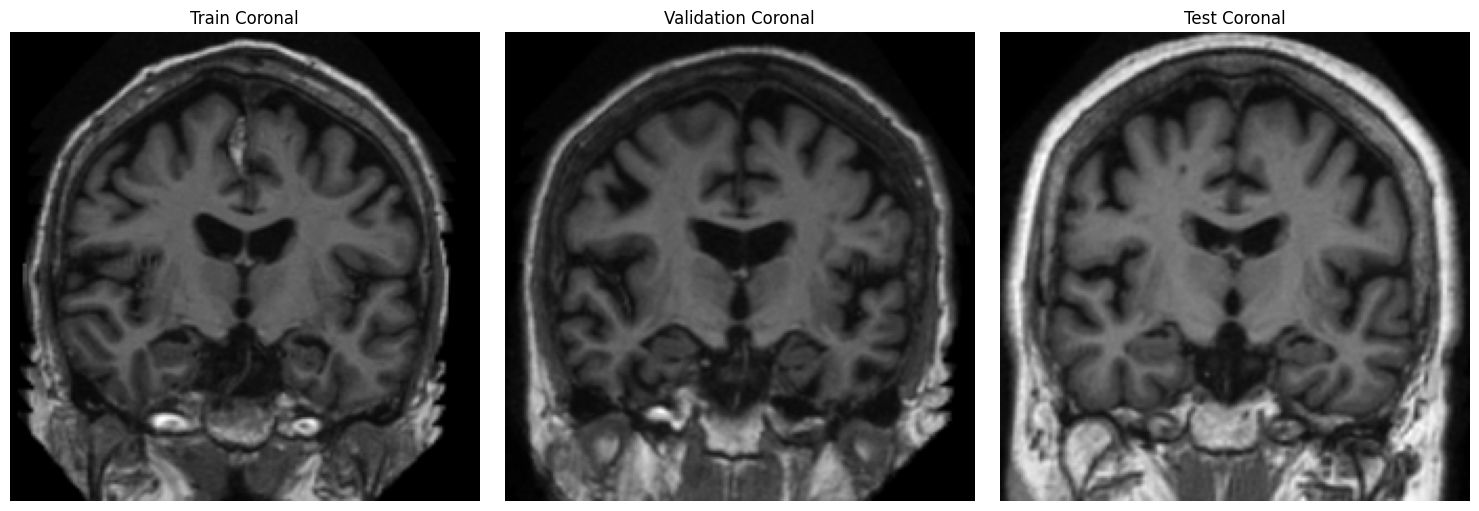

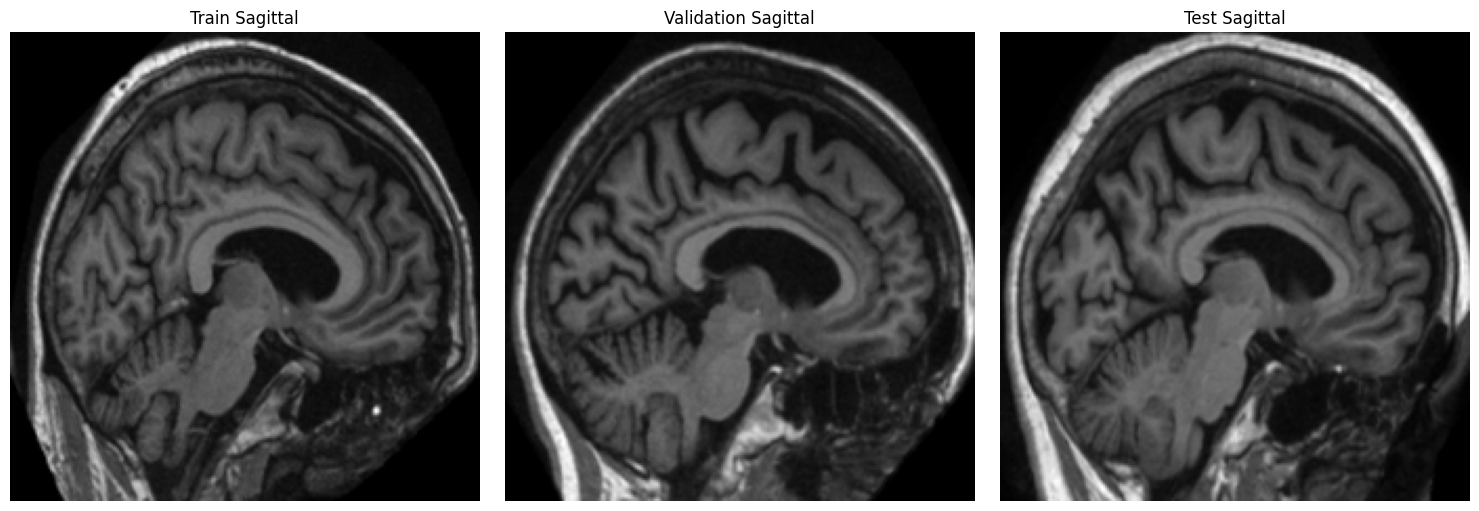

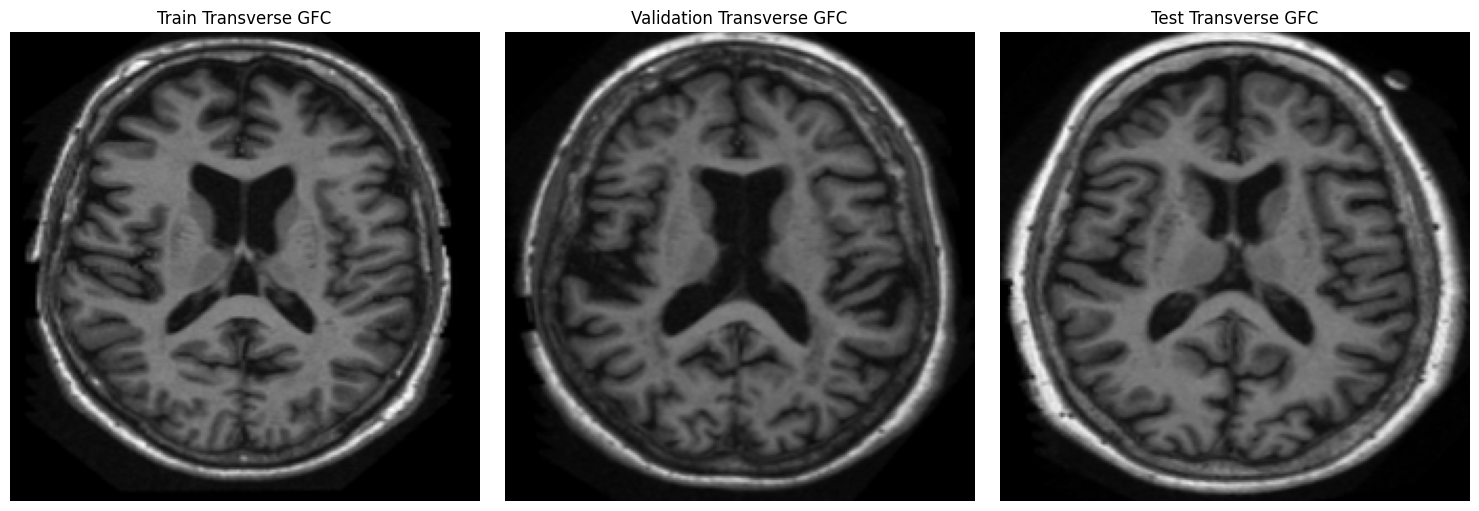

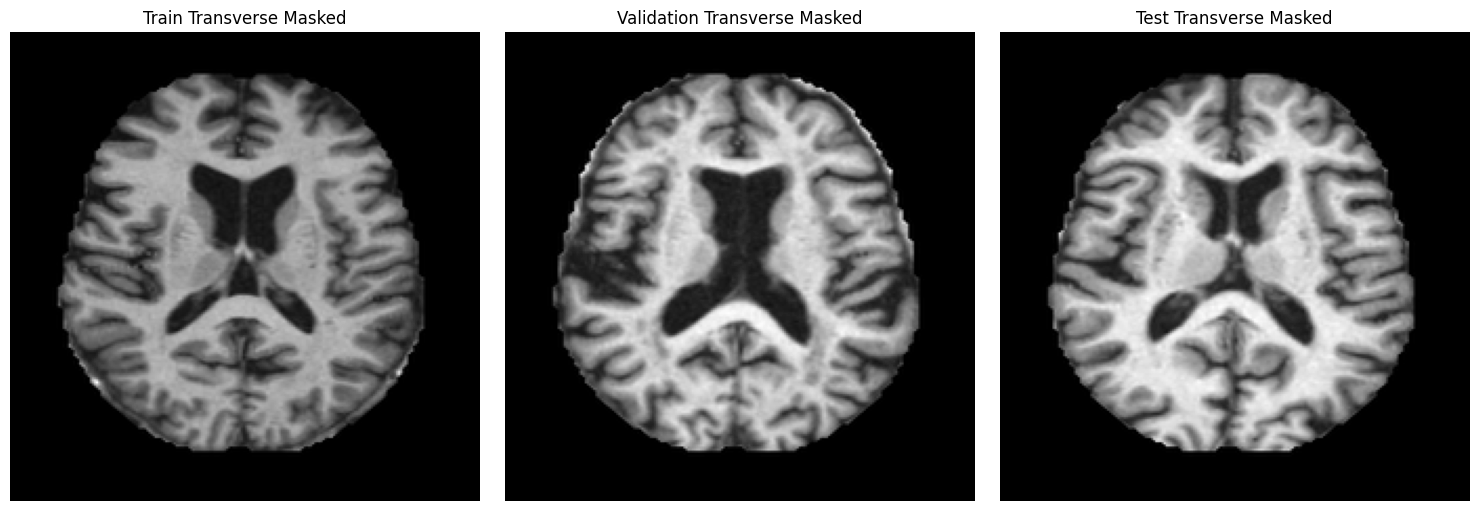

In [6]:
import matplotlib.pyplot as plt

# 이미지 시각화 함수 정의
def display_sample_images(image_arrays, titles, cmap='gray'):
    # 이미지 배열과 제목 리스트의 길이가 같아야 함
    assert len(image_arrays) == len(titles)
    
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(image_arrays, titles)):
        plt.subplot(1, len(image_arrays), i+1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 샘플 이미지를 시각화 (정규화된 이미지 확인)
def visualize_samples():
    # Coronal, Sagittal, Transverse 2종 각각 첫 번째 샘플 이미지 시각화
    sample_coronal = [train_coronal[0], val_coronal[0], test_coronal[0]]
    sample_sagittal = [train_sagittal[0], val_sagittal[0], test_sagittal[0]]
    sample_transverse_gfc = [train_transverse_gfc[0], val_transverse_gfc[0], test_transverse_gfc[0]]
    sample_transverse_masked = [train_transverse_masked[0], val_transverse_masked[0], test_transverse_masked[0]]
    
    # Coronal 이미지 시각화
    display_sample_images(sample_coronal, ["Train Coronal", "Validation Coronal", "Test Coronal"])
    
    # Sagittal 이미지 시각화
    display_sample_images(sample_sagittal, ["Train Sagittal", "Validation Sagittal", "Test Sagittal"])
    
    # Transverse GFC 이미지 시각화
    display_sample_images(sample_transverse_gfc, ["Train Transverse GFC", "Validation Transverse GFC", "Test Transverse GFC"])
    
    # Transverse Masked 이미지 시각화
    display_sample_images(sample_transverse_masked, ["Train Transverse Masked", "Validation Transverse Masked", "Test Transverse Masked"])

# 샘플 이미지 시각화 실행
visualize_samples()


# Graphs for Final Dataset

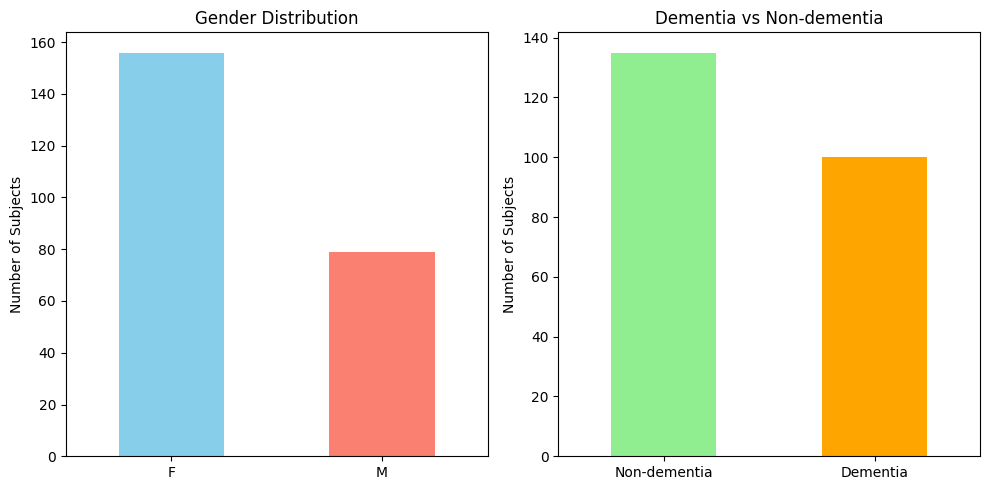

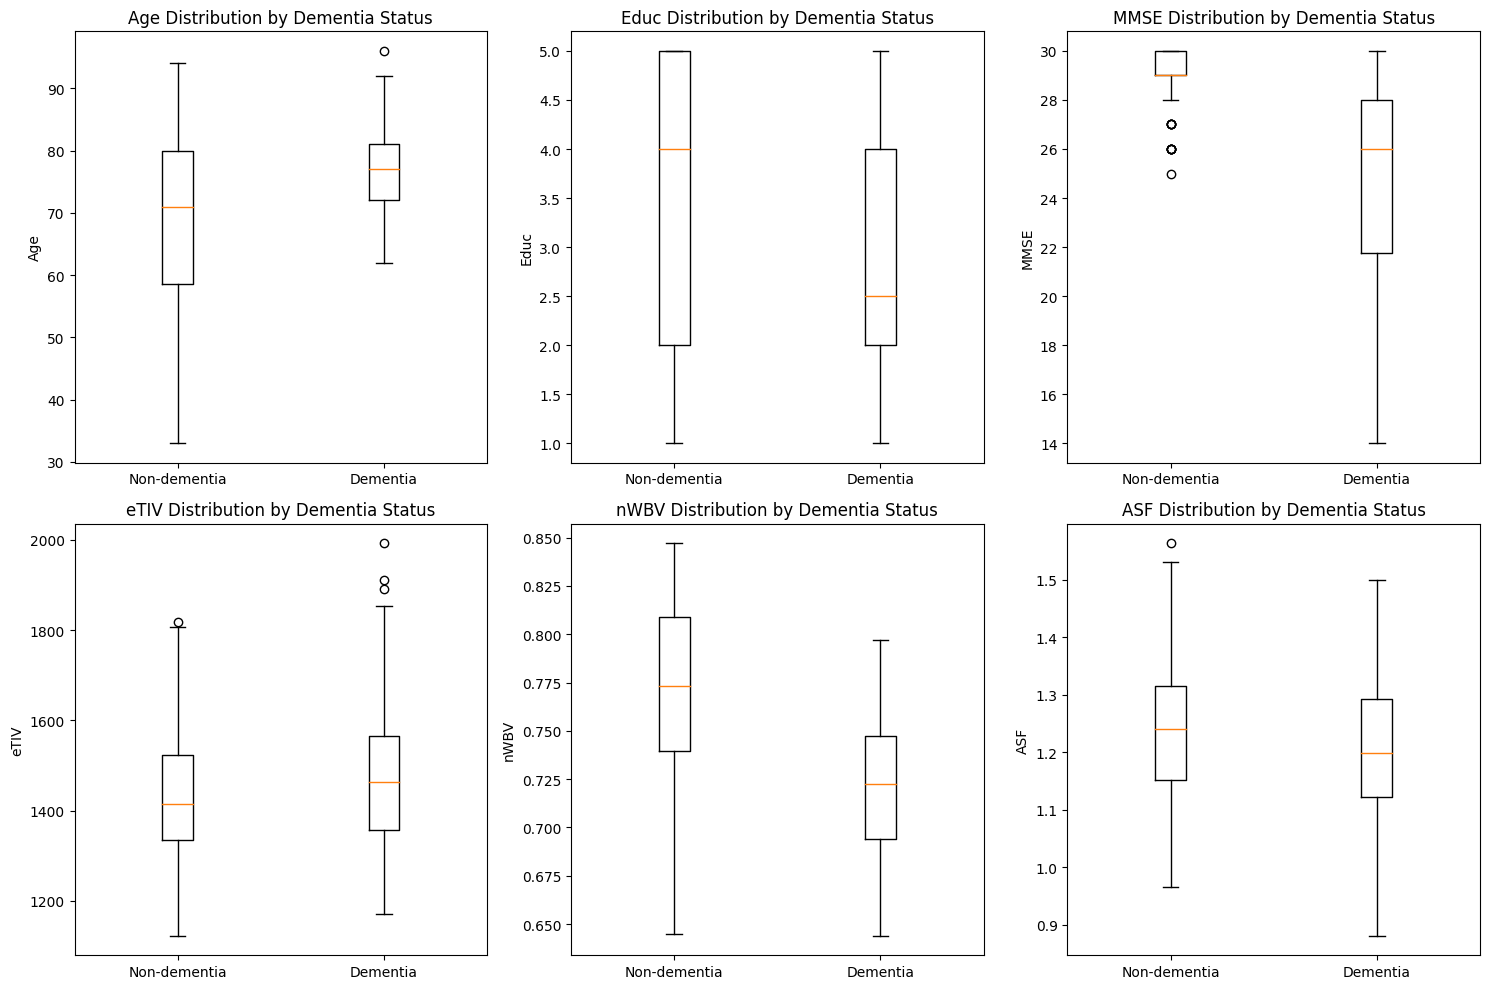

In [7]:
import matplotlib.pyplot as plt

# 인구통계 정보에서 가져오기
demographic_data = pd.DataFrame.from_dict(demographics, orient='index')

# 성별
gender_counts = demographic_data['M/F'].value_counts()

# 치매 여부 분포 (CDR 값이 0인 경우 비치매, 0.5 이상인 경우 치매)
dementia_counts = pd.Series({
    'Non-dementia': len([cdr for cdr in labels if cdr == 0]),
    'Dementia': len([cdr for cdr in labels if cdr >= 0.5])
})
# 그래프 그리기
plt.figure(figsize=(10, 5))

# 성별 분포 그래프
plt.subplot(1, 2, 1)
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Gender Distribution')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=0)

# 치매 여부 분포 그래프
plt.subplot(1, 2, 2)
dementia_counts.plot(kind='bar', color=['lightgreen', 'orange'])
plt.title('Dementia vs Non-dementia')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=0)

# 그래프 표시
plt.tight_layout()
plt.show()

# 치매 (CDR >= 0.5)와 비치매 (CDR == 0) 그룹 나누기
dementia_group = demographic_data.loc[[subject for subject, label in zip(demographic_data.index, labels) if label >= 0.5]]
non_dementia_group = demographic_data.loc[[subject for subject, label in zip(demographic_data.index, labels) if label == 0]]

# 박스플롯으로 각 변수 (Age, Educ, MMSE, eTIV, nWBV, ASF) 시각화
plt.figure(figsize=(15, 10))

variables = ['Age', 'Educ', 'MMSE', 'eTIV', 'nWBV', 'ASF']
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    plt.boxplot([non_dementia_group[var].dropna(), dementia_group[var].dropna()], labels=['Non-dementia', 'Dementia'])
    plt.title(f'{var} Distribution by Dementia Status')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


# GPU activation

In [2]:
import os
import tensorflow as tf

# CUDA 환경변수 초기화 (필요에 따라 GPU를 선택)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # 사용할 GPU를 '0'번으로 제한 (다수 사용시 '0,1'로 설정)

# GPU 장치 목록을 가져옵니다.
gpus = tf.config.list_physical_devices('GPU')

# GPU가 감지된 경우에만 설정을 적용합니다.
if gpus:
    try:
        # 메모리 증가 활성화 (동적 메모리 할당)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth successfully set for GPUs")

        # 또는 GPU 메모리 사용량을 제한할 수도 있습니다.
        # 4GB로 GPU 메모리 사용량을 제한하려면 아래처럼 설정하세요.
        # 메모리 사용량을 특정 크기로 제한할 때는 'virtual_device_configuration' 사용
        for gpu in gpus:
            tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])  # 4096 MB (4GB)로 제한
        print("Memory limit successfully set for GPUs")

    except RuntimeError as e:
        # GPU가 이미 초기화된 경우 발생하는 오류
        print(e)

# 이후 TensorFlow 관련 코드 작성 (모델 학습, 평가 등)

Memory growth successfully set for GPUs
Memory limit successfully set for GPUs


# CPU 설정

In [21]:
import os
import tensorflow as tf

# GPU를 비활성화하여 CPU만 사용하도록 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 이후부터는 TensorFlow가 CPU만 사용하게 됩니다.
print("Using CPU for TensorFlow")

# 이후 TensorFlow 관련 코드 작성 (모델 학습, 평가 등)


Num GPUs Available:  1


# pickle

In [8]:
import pickle

# 전처리된 데이터를 딕셔너리에 저장
data_to_save = {
    'train_coronal': train_coronal,
    'val_coronal': val_coronal,
    'test_coronal': test_coronal,
    'train_sagittal': train_sagittal,
    'val_sagittal': val_sagittal,
    'test_sagittal': test_sagittal,
    'train_transverse_gfc': train_transverse_gfc,
    'val_transverse_gfc': val_transverse_gfc,
    'test_transverse_gfc': test_transverse_gfc,
    'train_transverse_masked': train_transverse_masked,
    'val_transverse_masked': val_transverse_masked,
    'test_transverse_masked': test_transverse_masked,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels
}

# 데이터를 pickle 파일로 저장
with open('preprocessed_dataset1007.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("데이터가 'preprocessed_dataset1007.pkl' 파일로 저장되었습니다.")


데이터가 'preprocessed_dataset1007.pkl' 파일로 저장되었습니다.


# pickle load

In [2]:
import pickle

# pickle 파일로부터 데이터 로드
with open('preprocessed_dataset1007.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 로드된 데이터를 필요한 변수에 할당
train_coronal = loaded_data['train_coronal']
val_coronal = loaded_data['val_coronal']
test_coronal = loaded_data['test_coronal']
train_sagittal = loaded_data['train_sagittal']
val_sagittal = loaded_data['val_sagittal']
test_sagittal = loaded_data['test_sagittal']
train_transverse_gfc = loaded_data['train_transverse_gfc']
val_transverse_gfc = loaded_data['val_transverse_gfc']
test_transverse_gfc = loaded_data['test_transverse_gfc']
train_transverse_masked = loaded_data['train_transverse_masked']
val_transverse_masked = loaded_data['val_transverse_masked']
test_transverse_masked = loaded_data['test_transverse_masked']
train_labels = loaded_data['train_labels']
val_labels = loaded_data['val_labels']
test_labels = loaded_data['test_labels']

print("데이터가 'preprocessed_dataset10007.pkl' 파일로부터 로드되었습니다.")


데이터가 'preprocessed_dataset10007.pkl' 파일로부터 로드되었습니다.


# 1008 모델 시도

In [1]:
from keras.callbacks import EarlyStopping

epochs=200
batch_size = 32
learning_rate=0.0001
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 1
https://github.com/clin-projects/MRI-alzheimers-classification-OASIS1-/blob/master/oasis-alzheimer-regression.ipynb

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.5429WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022B8F4185E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

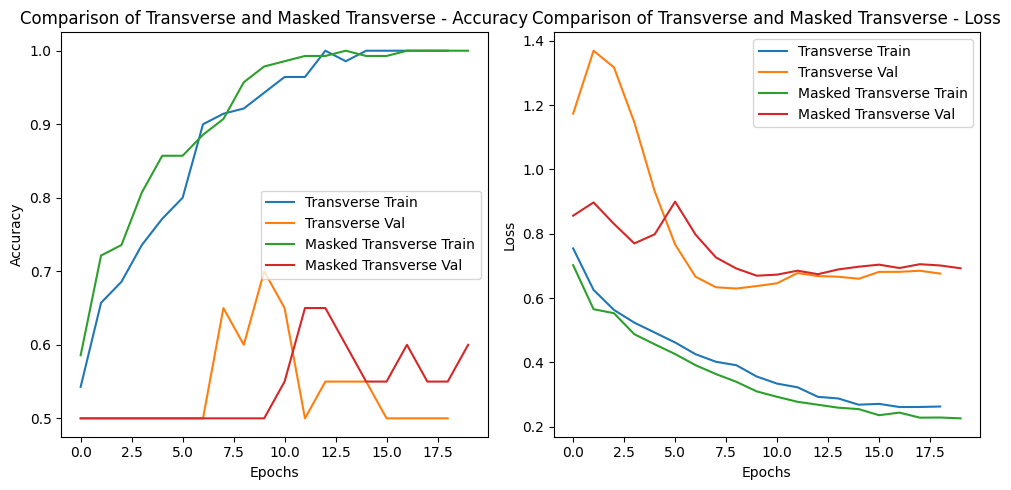

In [25]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
import numpy as np
from keras.callbacks import EarlyStopping
####################################
## 5. 데이터 준비
####################################
# Transverse와 Masked Transverse 데이터를 준비

# Transverse 데이터 평탄화
X_train_transverse = train_transverse_gfc.reshape(train_transverse_gfc.shape[0], -1)
X_val_transverse = val_transverse_gfc.reshape(val_transverse_gfc.shape[0], -1)
X_test_transverse = test_transverse_gfc.reshape(test_transverse_gfc.shape[0], -1)

# Masked Transverse 데이터 평탄화
X_train_masked = train_transverse_masked.reshape(train_transverse_masked.shape[0], -1)
X_val_masked = val_transverse_masked.reshape(val_transverse_masked.shape[0], -1)
X_test_masked = test_transverse_masked.reshape(test_transverse_masked.shape[0], -1)

# 레이블은 동일하므로 재사용
Y_train = np.eye(2)[train_labels]
Y_val = np.eye(2)[val_labels]
Y_test = np.eye(2)[test_labels]

####################################
## 6. 모델 정의 함수 (early stopping 추가)
####################################
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))  # 2개의 클래스 (치매, 비치매)

    adam = Adam(learning_rate=learning_rate)  # lr 대신 learning_rate 사용
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

####################################
## 7. Transverse 데이터 학습
####################################
model_transverse = create_model(X_train_transverse.shape[1])
history_transverse = model_transverse.fit(
    X_train_transverse, Y_train, validation_data=(X_val_transverse, Y_val),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping]  # Early Stopping 추가
)

# 테스트 평가
test_loss_transverse, test_acc_transverse = model_transverse.evaluate(X_test_transverse, Y_test, verbose=2)
print(f"Transverse Test Accuracy: {test_acc_transverse}")

####################################
## 8. Masked Transverse 데이터 학습
####################################
model_masked = create_model(X_train_masked.shape[1])
history_masked = model_masked.fit(
    X_train_masked, Y_train, validation_data=(X_val_masked, Y_val),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping]  # Early Stopping 추가
)

# 테스트 평가
test_loss_masked, test_acc_masked = model_masked.evaluate(X_test_masked, Y_test, verbose=2)
print(f"Masked Transverse Test Accuracy: {test_acc_masked}")

####################################
## 9. 정확도 및 로스 그래프 그리기
####################################
# 학습 정확도와 손실을 시각화
def plot_history(histories, title):
    plt.figure(figsize=(10, 5))

    # 정확도
    plt.subplot(1, 2, 1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 두 모델의 학습 결과를 시각화
plot_history(
    [('Transverse', history_transverse), ('Masked Transverse', history_masked)],
    'Comparison of Transverse and Masked Transverse'
)


수정ver
1. 모델층 추가
2. dropout 추가
3. lr 조정 (빠른 학습)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/5 [=======================>......] - ETA: 0s - loss: 1.3841 - accuracy: 0.4688WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022C404EB438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

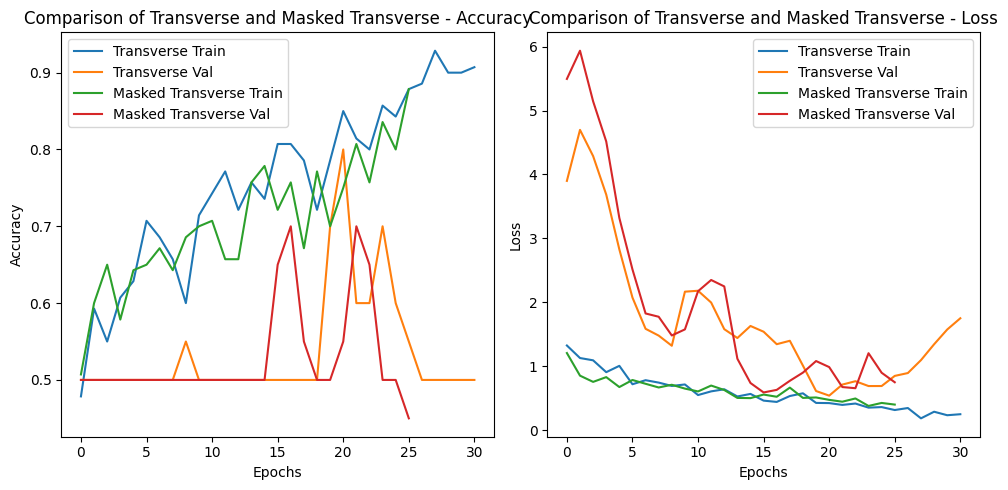

In [27]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
import numpy as np
####################################
## 5. 데이터 준비
####################################
# Transverse와 Masked Transverse 데이터를 준비합니다.

# Transverse 데이터 평탄화
X_train_transverse = train_transverse_gfc.reshape(train_transverse_gfc.shape[0], -1)
X_val_transverse = val_transverse_gfc.reshape(val_transverse_gfc.shape[0], -1)
X_test_transverse = test_transverse_gfc.reshape(test_transverse_gfc.shape[0], -1)

# Masked Transverse 데이터 평탄화
X_train_masked = train_transverse_masked.reshape(train_transverse_masked.shape[0], -1)
X_val_masked = val_transverse_masked.reshape(val_transverse_masked.shape[0], -1)
X_test_masked = test_transverse_masked.reshape(test_transverse_masked.shape[0], -1)

# 레이블은 동일하므로 재사용
Y_train = np.eye(2)[train_labels]
Y_val = np.eye(2)[val_labels]
Y_test = np.eye(2)[test_labels]

####################################
## 6. 모델 정의 함수 (수정된 부분)
####################################
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Dropout 추가

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Dropout 추가

    model.add(Dense(2, activation='softmax'))  # 2개의 클래스

    # Adam 옵티마이저에서 learning_rate를 0.001로 변경
    adam = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model


####################################
## 7. Transverse 데이터 학습
####################################
model_transverse = create_model(X_train_transverse.shape[1])
history_transverse = model_transverse.fit(
    X_train_transverse, Y_train, validation_data=(X_val_transverse, Y_val),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping]  # Early Stopping 추가
)

# 테스트 평가
test_loss_transverse, test_acc_transverse = model_transverse.evaluate(X_test_transverse, Y_test, verbose=2)
print(f"Transverse Test Accuracy: {test_acc_transverse}")

####################################
## 8. Masked Transverse 데이터 학습
####################################
model_masked = create_model(X_train_masked.shape[1])
history_masked = model_masked.fit(
    X_train_masked, Y_train, validation_data=(X_val_masked, Y_val),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping]  # Early Stopping 추가
)

# 테스트 평가
test_loss_masked, test_acc_masked = model_masked.evaluate(X_test_masked, Y_test, verbose=2)
print(f"Masked Transverse Test Accuracy: {test_acc_masked}")

####################################
## 9. 정확도 및 로스 그래프 그리기
####################################
# 학습 정확도와 손실을 시각화
def plot_history(histories, title):
    plt.figure(figsize=(10, 5))

    # 정확도
    plt.subplot(1, 2, 1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 두 모델의 학습 결과를 시각화
plot_history(
    [('Transverse', history_transverse), ('Masked Transverse', history_masked)],
    'Comparison of Transverse and Masked Transverse'
)


In [28]:
import os
import tensorflow as tf

# GPU 비활성화
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [31]:
from keras.callbacks import EarlyStopping

epochs=200
batch_size = 3
learning_rate=0.0001
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 2
https://www.kaggle.com/code/jeongwoopark/alzheimer-detection-and-classification-98-7-acc

1. VGG16

배치를 아주 작게(batch_size=3) 조정했는데도 여전히 OOM

In [32]:
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Convert grayscale to 3-channel RGB for VGG16
def to_rgb(img):
    img_rgb = np.repeat(img, 3, axis=-1)
    return img_rgb

# Convert and stack images
def convert_to_rgb(image_array):
    rgb_list = [to_rgb(img) for img in image_array]
    return np.stack(rgb_list)

# Prepare the RGB datasets
train_transverse_gfc_rgb = convert_to_rgb(train_transverse_gfc)
val_transverse_gfc_rgb = convert_to_rgb(val_transverse_gfc)
test_transverse_gfc_rgb = convert_to_rgb(test_transverse_gfc)

train_transverse_masked_rgb = convert_to_rgb(train_transverse_masked)
val_transverse_masked_rgb = convert_to_rgb(val_transverse_masked)
test_transverse_masked_rgb = convert_to_rgb(test_transverse_masked)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)
y_test_encoded = label_encoder.transform(test_labels)

# Define VGG16 model
vgg16 = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
vgg16.trainable = False

# Transverse Images VGG16 Model
vgg16_model_transverse = Sequential()
vgg16_model_transverse.add(vgg16)
vgg16_model_transverse.add(Flatten(name='flatten'))
vgg16_model_transverse.add(Dense(2, activation='softmax', name='predictions'))
vgg16_model_transverse.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Transverse Masked Images VGG16 Model
vgg16_model_transverse_masked = Sequential()
vgg16_model_transverse_masked.add(vgg16)
vgg16_model_transverse_masked.add(Flatten(name='flatten'))
vgg16_model_transverse_masked.add(Dense(2, activation='softmax', name='predictions'))
vgg16_model_transverse_masked.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train VGG16 with Transverse Images
history_transverse = vgg16_model_transverse.fit(train_transverse_gfc_rgb, y_train_encoded, 
                                                validation_data=(val_transverse_gfc_rgb, y_val_encoded), 
                                                epochs=epochs, batch_size=batch_size, verbose=1,
                                                callbacks=[early_stopping])  # Early Stopping 추가)

# Train VGG16 with Masked Transverse Images
history_masked = vgg16_model_transverse_masked.fit(train_transverse_masked_rgb, y_train_encoded, 
                                                   validation_data=(val_transverse_masked_rgb, y_val_encoded), 
                                                   epochs=epochs, batch_size=batch_size, verbose=1,
                                                   callbacks=[early_stopping])  # Early Stopping 추가)

# Evaluate models
print("Evaluation for VGG16 on Transverse Images:")
vgg16_model_transverse.evaluate(test_transverse_gfc_rgb, y_test_encoded)

print("Evaluation for VGG16 on Masked Transverse Images:")
vgg16_model_transverse_masked.evaluate(test_transverse_masked_rgb, y_test_encoded)

####################################
## 9. 정확도 및 로스 그래프 그리기
####################################
# 학습 정확도와 손실을 시각화
def plot_history(histories, title):
    plt.figure(figsize=(10, 5))

    # 정확도
    plt.subplot(1, 2, 1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 두 모델의 학습 결과를 시각화
plot_history(
    [('Transverse', history_transverse), ('Masked Transverse', history_masked)],
    'Comparison of Transverse and Masked Transverse'
)


Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - ETA: 0s - loss: 1.5792 - accuracy: 0.5071WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022C3CB71B88> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_28/vgg16/block1_conv2/Relu' defined at (most recent call last):
    File "c:\Users\USER\.conda\envs\syrr\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\USER\.conda\envs\syrr\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\USER\.conda\envs\syrr\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\USER\.conda\envs\syrr\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\USER\.conda\envs\syrr\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_26568\666994934.py", line 53, in <module>
      callbacks=[early_stopping])  # Early Stopping 추가)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1617, in fit
      _use_cached_eval_dataset=True,
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "c:\Users\USER\.conda\envs\syrr\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_28/vgg16/block1_conv2/Relu'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_28/vgg16/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_83411]

2. EfficientNetB0

마찬가지로 메모리가 터짐

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.6143WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022C3DAEE948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

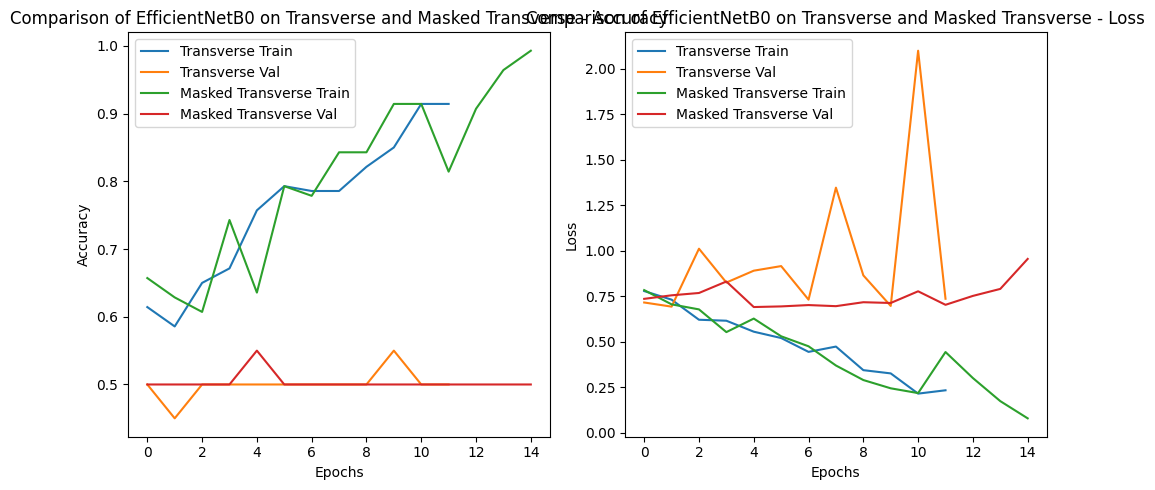

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Convert grayscale to 3-channel RGB for EfficientNetB0
def to_rgb(img):
    img_rgb = np.repeat(img, 3, axis=-1)  # 흑백 이미지를 3채널로 변환
    return img_rgb

# Convert and stack images
def convert_to_rgb(image_array):
    rgb_list = [to_rgb(img) for img in image_array]
    return np.stack(rgb_list)

# Prepare the RGB datasets (convert grayscale to RGB)
train_transverse_gfc_rgb = convert_to_rgb(train_transverse_gfc)
val_transverse_gfc_rgb = convert_to_rgb(val_transverse_gfc)
test_transverse_gfc_rgb = convert_to_rgb(test_transverse_gfc)

train_transverse_masked_rgb = convert_to_rgb(train_transverse_masked)
val_transverse_masked_rgb = convert_to_rgb(val_transverse_masked)
test_transverse_masked_rgb = convert_to_rgb(test_transverse_masked)

# Define EfficientNetB0 model for RGB images
def create_efficientnet_model(input_shape):
    EffNet = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
    EffNet.trainable = True
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    x = EffNet(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='output_layer')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Set input shape for RGB images (3 channels)
input_shape = (224, 224, 3)

# Transverse EfficientNetB0 Model
efficientnet_model_transverse = create_efficientnet_model(input_shape)
history_transverse = efficientnet_model_transverse.fit(train_transverse_gfc_rgb, y_train_encoded, validation_data=(val_transverse_gfc_rgb, y_val_encoded), epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping] ) # Early Stopping 추가

# Transverse Masked EfficientNetB0 Model
efficientnet_model_transverse_masked = create_efficientnet_model(input_shape)
history_masked = efficientnet_model_transverse_masked.fit(train_transverse_masked_rgb, y_train_encoded, 
                                                          validation_data=(val_transverse_masked_rgb, y_val_encoded), 
                                                          epochs=epochs, batch_size=batch_size, verbose=1,
                                                          callbacks=[early_stopping] ) # Early Stopping 추가

# Evaluate models
print("Evaluation for EfficientNetB0 on Transverse Images:")
efficientnet_model_transverse.evaluate(test_transverse_gfc_rgb, y_test_encoded)

print("Evaluation for EfficientNetB0 on Masked Transverse Images:")
efficientnet_model_transverse_masked.evaluate(test_transverse_masked_rgb, y_test_encoded)

####################################
## 정확도 및 손실 그래프 그리기
####################################
# 학습 정확도와 손실을 시각화
def plot_history(histories, title):
    plt.figure(figsize=(10, 5))

    # 정확도
    plt.subplot(1, 2, 1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 두 모델의 학습 결과를 시각화
plot_history(
    [('Transverse', history_transverse), ('Masked Transverse', history_masked)],
    'Comparison of EfficientNetB0 on Transverse and Masked Transverse'
)


# 모델 3 : 더 깊은 CNN layer
https://github.com/anilmenon14/OASIS_CNN_dementia_patterns

In [2]:
from keras.callbacks import EarlyStopping

epochs=200
batch_size = 16
learning_rate=0.0001
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.4571WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA5186DEE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

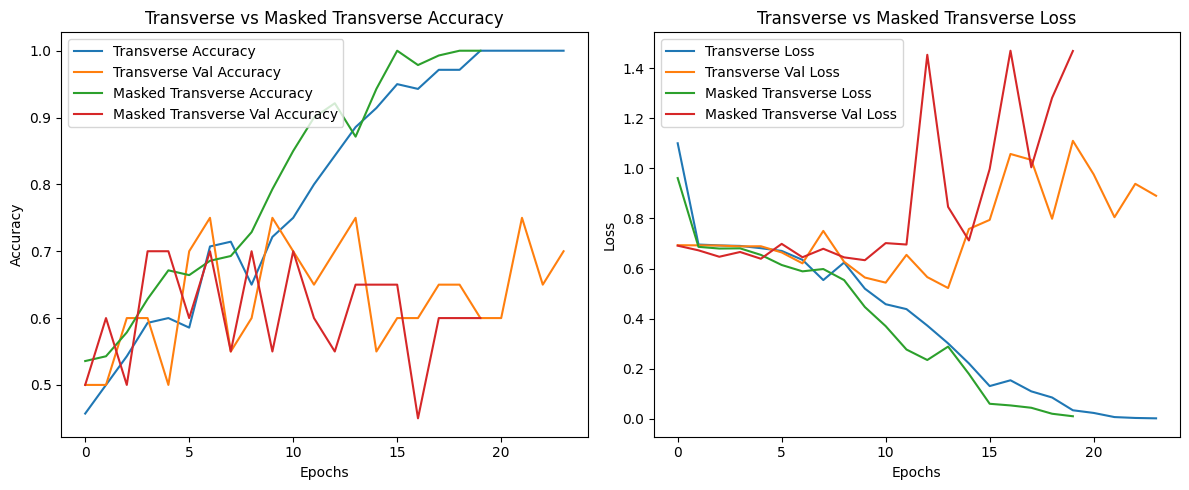

In [3]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import numpy as np

# 모델 정의
def generate_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax')) 
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 모델 학습 및 평가 함수 정의
def generate_and_train_model(train_data, val_data, test_data, train_labels, val_labels, test_labels, input_shape):
    model = generate_model(input_shape)
    
    # 모델 학습
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                        epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stopping] )# Early Stopping 추가)
    
    # 모델 평가
    test_loss, test_accuracy = model.evaluate(test_data, test_labels)
    
    return model, history, test_loss, test_accuracy

# 라벨을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# 입력 데이터 형태 정의 (이미 전처리된 데이터 사용)
transverse_input_shape = (224, 224, 1)  # Transverse 이미지 크기
masked_transverse_input_shape = (224, 224, 1)  # Masked Transverse 이미지 크기

# Transverse 이미지 모델 학습 및 평가
transverse_model, transverse_history, transverse_test_loss, transverse_test_accuracy = generate_and_train_model(
    train_transverse_gfc, val_transverse_gfc, test_transverse_gfc,
    train_labels, val_labels, test_labels, transverse_input_shape
)

# Masked Transverse 이미지 모델 학습 및 평가
masked_transverse_model, masked_transverse_history, masked_transverse_test_loss, masked_transverse_test_accuracy = generate_and_train_model(
    train_transverse_masked, val_transverse_masked, test_transverse_masked,
    train_labels, val_labels, test_labels, masked_transverse_input_shape
)

# 학습 결과 출력
print(f"Transverse 모델 테스트 정확도: {transverse_test_accuracy}")
print(f"Masked Transverse 모델 테스트 정확도: {masked_transverse_test_accuracy}")

# 정확도와 손실 그래프 그리기
def plot_accuracy_and_loss(history1, history2, title):
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Transverse Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Transverse Val Accuracy')
    plt.plot(history2.history['accuracy'], label='Masked Transverse Accuracy')
    plt.plot(history2.history['val_accuracy'], label='Masked Transverse Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Transverse Loss')
    plt.plot(history1.history['val_loss'], label='Transverse Val Loss')
    plt.plot(history2.history['loss'], label='Masked Transverse Loss')
    plt.plot(history2.history['val_loss'], label='Masked Transverse Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 정확도와 손실 그래프 출력
plot_accuracy_and_loss(transverse_history, masked_transverse_history, 'Transverse vs Masked Transverse')


# 모델 4
https://github.com/GMattheisen/predicting_Alzheimers_from_MRI

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.5143WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D72F56FC18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

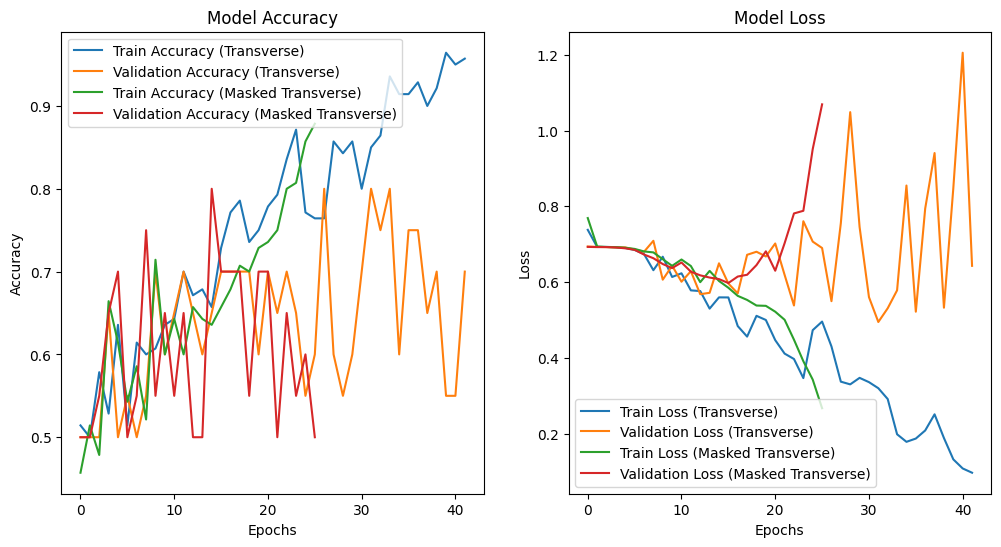

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 라벨을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

####################################
## 5. Model Definition and Training
####################################

# Define the CNN model from the repository
def build_alzheimer_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Adjusted for binary classification (Dementia vs Non-dementia)

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Set input shape
input_shape = (224, 224, 1)

# Build models for both transverse and masked transverse data
transverse_model = build_alzheimer_model(input_shape)
masked_transverse_model = build_alzheimer_model(input_shape)

# Train and validate the models
history_transverse = transverse_model.fit(
    train_transverse_gfc, 
    train_labels, 
    validation_data=(val_transverse_gfc, val_labels),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping] # Early Stopping 추가)
)

history_masked_transverse = masked_transverse_model.fit(
    train_transverse_masked, 
    train_labels, 
    validation_data=(val_transverse_masked, val_labels),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping] # Early Stopping 추가)
)

# Evaluate the models
print("Transverse Model Evaluation:")
transverse_eval = transverse_model.evaluate(test_transverse_gfc, test_labels)
print("Masked Transverse Model Evaluation:")
masked_transverse_eval = masked_transverse_model.evaluate(test_transverse_masked, test_labels)

# Plot the accuracy and loss for both models
plt.figure(figsize=(12, 6))

# Transverse Model Accuracy and Loss
plt.subplot(1, 2, 1)
plt.plot(history_transverse.history['accuracy'], label='Train Accuracy (Transverse)')
plt.plot(history_transverse.history['val_accuracy'], label='Validation Accuracy (Transverse)')
plt.plot(history_masked_transverse.history['accuracy'], label='Train Accuracy (Masked Transverse)')
plt.plot(history_masked_transverse.history['val_accuracy'], label='Validation Accuracy (Masked Transverse)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Transverse Model Loss
plt.subplot(1, 2, 2)
plt.plot(history_transverse.history['loss'], label='Train Loss (Transverse)')
plt.plot(history_transverse.history['val_loss'], label='Validation Loss (Transverse)')
plt.plot(history_masked_transverse.history['loss'], label='Train Loss (Masked Transverse)')
plt.plot(history_masked_transverse.history['val_loss'], label='Validation Loss (Masked Transverse)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
